In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

import tensorflow as tf
import pandas as pd
import re

from sklearn.utils import shuffle

import re
import string

from nltk.tokenize import word_tokenize
from transformers import TFAutoModel, XLNetTokenizerFast

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

pylab.rcParams['figure.figsize'] = (3.0, 4)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Sentiment Analysis


In [5]:
sntiment_path = '..\Data\sentiment\data.csv'

sentiment_df = pd.read_csv(sntiment_path, encoding='latin-1', header=None)

usecols = ['Sentiment', "ID", 'Date', 'Query', 'User', 'Text']
sentiment_df.columns = usecols
sentiment_df = sentiment_df.drop(['ID', 'Date', 'User', 'Query'], axis=1)
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace(4, 1)

sentiment_df = shuffle(sentiment_df).reset_index(drop=True)

In [6]:
tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased')

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])

    return punctuationfree

def lower_text(text):
    return text.lower()

def stripper(text):  # removing extra white spaces
    return text.strip()

def remove_stopwords(text):

    tokens = word_tokenize(text)

    result = " ".join(
        [i for i in tokens if not i in stopwords.words('english')])
    return result

def preprocess_text(text):  # returns tokenized text

    text = remove_url(text)
    text = stripper(text)
    text = lower_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    # text = tokenizer(text, return_tensors="np", padding=True, max_length=30)['input_ids']

    # text = np.asarray(text).astype('int32')
    return text

In [7]:
sentiment_df['Text'] = sentiment_df['Text'].map(preprocess_text)
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].map(
    lambda x: np.asarray(x).astype('int32'))

In [9]:
sentiment_df.tail()

,Sentiment,Text
1599995,0,alone friday night
1599996,1,completely screwed cakeoops least tastes good ...
1599997,0,ahhh car journeys long im enjoying looking hai...
1599998,0,day
1599999,1,skquinn doesnt sound fair right really see you...


In [11]:
sentiment_text_train, sentiment_x_test = sentiment_df['Text'][:
                                                              1500000].values, sentiment_df['Text'][1500000:].values
sentiment_text_train = tokenizer(list(sentiment_text_train),
                                 return_tensors="tf",
                                 padding=True,
                                 max_length=30,
                                 truncation=True)['input_ids']

sentiment_x_test = tokenizer(list(sentiment_x_test),
                             return_tensors="tf",
                             padding=True,
                             max_length=30,
                             truncation=True)['input_ids']

sentiment_y_train, sentiment_y_test = sentiment_df['Sentiment'][:1500000].values.reshape(
    -1, 1), sentiment_df['Sentiment'][1500000:].values.reshape(-1, 1)


sentiment_y_train = np.asarray(sentiment_y_train).astype('int8')


sentiment_y_test = np.asarray(sentiment_y_test).astype('int8')

In [8]:
model_name = 'xlnet-base-cased'
# XLNet Model with a sequence classification/regression head on top


xlnetPretrainedModel = TFAutoModel.from_pretrained(model_name)
for layer in xlnetPretrainedModel.layers:
    layer.trainable = True

e:\Apps\conda\envs\TensorFlow_GPU\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers o

In [12]:
input_ids = tf.keras.layers.Input(shape=(30,), name='input_ids', dtype='int32')
# mask = tf.keras.layers.Input(shape=(30,), name='attention_mask', dtype='int32')

# embeddings = xlnetPretrainedModel(input_ids, attention_mask=mask)[0]
embeddings = xlnetPretrainedModel(input_ids, training=False)[
    'last_hidden_state']
embeddings = embeddings[:, 0, :]

x = tf.keras.layers.Dense(512, activation='sigmoid')(embeddings)
x = tf.keras.layers.Dense(512, activation='sigmoid')(x)
x = tf.keras.layers.Dense(512, activation='sigmoid')(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(x)

sentiment_model = tf.keras.Model(inputs=[input_ids], outputs=y)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()

sentiment_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

In [17]:
history = sentiment_model.fit(
    sentiment_text_train,
    sentiment_y_train,
    validation_data=(sentiment_x_test, sentiment_y_test),
    epochs=3,
    batch_size=64)

Epoch 1/3
 5076/23438 [=====>........................] - ETA: 1:01:26 - loss: 0.3389 - accuracy: 0.8515

KeyboardInterrupt: 

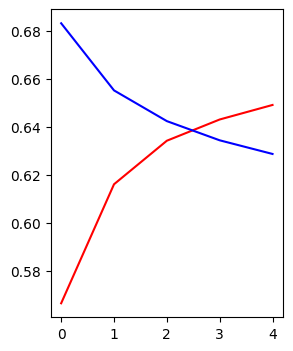

In [ ]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['loss'], 'b')

In [ ]:
# ! mkdir /content/drive/MyDrive/sentiment_model

In [48]:
sentiment_model.load_weights(
    '/content/drive/MyDrive/sentiment_model/sentiment_model.h5')

In [ ]:
# sentiment_model.save_weights('/content/drive/MyDrive/sentiment_model/sentiment_model.h5')

In [ ]:
sentiment_model.evaluate(sentiment_x_test, sentiment_y_test)

3125/3125 [==============================] - 252s 81ms/step - loss: 0.6042 - accuracy: 0.6733


[0.604174792766571, 0.673259973526001]